In [144]:
using PyPlot
using HDF5,FFTW,FourierFlows
using LinearAlgebra: mul!, ldiv!
using Statistics

In [7]:
f = h5open("/mnt/d/data/Simulation/SpectralJulia/Spectral_A_t_179.h5","r")
iv = read(f, "i_velocity",  );
jv = read(f, "j_velocity",  );
kv = read(f, "k_velocity",  );
ib = read(f, "i_mag_field", );
jb = read(f, "j_mag_field", );
kb = read(f, "k_mag_field", );
close(f)

In [119]:
function Curl(B1,B2,B3;Lx = 2π)
    #funtion of computing ∇×Vector using the fourier method
    # fft(∇×Vector) -> im * k × V
    #| i j k  |
    #| x y z  |
    #|B1 B2 B3|
    # (y*B3 - z*B2) i - (x*B3 - z*B1) j + (x*B2 - y*B1) k
    nx,ny,nz = size(B1);
    T    = Float32;
    grid = ThreeDGrid(nx, Lx, T = T);
    
    B1h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B2h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B3h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    cBxh = copy(B1h); 
    cByh = copy(B2h);
    cBzh = copy(B3h);
    mul!(B1h, grid.rfftplan, B1); 
    mul!(B2h, grid.rfftplan, B2); 
    mul!(B3h, grid.rfftplan, B3);
        
    for i in 1:div(nz,2)+1, j in 1:div(ny,2), k in 1:div(nx,2)
       x,y,z = grid.kr[i],grid.l[j],grid.m[k]; 
       cBxh[i,j,k] = im*(y*B3h[i,j,k] - z*B2h[i,j,k]);
       cByh[i,j,k] = im*(z*B1h[i,j,k] - x*B3h[i,j,k]);
       cBzh[i,j,k] = im*(x*B2h[i,j,k] - y*B1h[i,j,k]);
    end
    
    cB1,cB2,cB3 = zeros(T,size(B1)),zeros(T,size(B1)),zeros(T,size(B1));
    ldiv!(cB1, grid.rfftplan, deepcopy(cBxh));  
    ldiv!(cB2, grid.rfftplan, deepcopy(cByh));
    ldiv!(cB3, grid.rfftplan, deepcopy(cBzh));
    return cB1,cB2,cB3;
end

function Div(B1,B2,B3;Lx = 2π)
    #funtion of computing ∇̇ ⋅ Vector using the fourier method
    # fft(∇̇ ⋅ Vector) -> im * k ⋅ V
    # = im* x*B1 + y*B2 + z*B3
    nx,ny,nz = size(B1);
    T    = Float32;
    grid = ThreeDGrid(nx, Lx, T = T);
    
    B1h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B2h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B3h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    Dot = copy(B1h);
    mul!(B1h, grid.rfftplan, B1); 
    mul!(B2h, grid.rfftplan, B2); 
    mul!(B3h, grid.rfftplan, B3);
        
    for i in 1:div(nz,2)+1, j in 1:div(ny,2), k in 1:div(nx,2)
       x,y,z = grid.kr[i],grid.l[j],grid.m[k]; 
       Dot[i,j,k] = x*B1h[i,j,k] + y*B2h[i,j,k] + z*B3h[i,j,k];
    end
    
    cB1 = zeros(T,size(B1))
    ldiv!(cB1, grid.rfftplan, deepcopy(Dot));  

    return cB1
end

Div (generic function with 1 method)

In [140]:
Lx = 2π
l = 2*Lx;
N = size(iv)[1];
grid = ThreeDGrid(nx, Lx, T = Float32);
xx,yy,zz = copy(iv),copy(iv),copy(iv);
for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = l*grid.x[i];
    yy[i,j,k] = l*grid.y[j];
    zz[i,j,k] = l*grid.z[k];
end

ux = @.   cos(yy);# sin(xx)*cos(yy)*cos(zz);
uy = @.  -0*cos(xx);#*sin(yy)*cos(zz);
uz = @.  0*sin(xx);



In [141]:
cV1,cV2,cV3 = Curl(ux,uy,uz);
h_k = sum(cV1.*ux.+ cV2.*uy .+ cV3.*uz)*dV

0.0

In [154]:
mean(iv),mean(jv),mean(kv)

(-0.00018496392f0, -0.0014910311f0, 0.00032358087f0)

In [152]:
# V ⋅ ( ∇ × V )
dV  = 2π/size(iv)[1];
cV1,cV2,cV3 = crossproduct(iv.-mean(iv),jv.-mean(jv),kv.-mean(kv));
h_k = mean(cV1.*(iv .- mean(iv)) .+ cV2.*(jv .- mean(jv)) .+ cV3.*(kv .- mean(kv)))*dV

2.478699676362216e-6

In [153]:
# j ⋅ b = (∇ × b) ⋅ (b) 
# V ⋅ ( ∇ × V )
cb1,cb2,cb3 = crossproduct(ib.-mean(ib),jb.-mean(jb),kb.-mean(kb));
h_m = mean(cb1.*(ib .- mean(ib)) .+ cb2.*(jb .- mean(jb)) .+ cb3.*(kb .- mean(kb)))*dV

1.7028437874216578e-6

In [155]:
mean(ib),mean(jb),mean(kb)

(-8.731149f-10, -5.820766f-11, -1.1368684f-12)

In [128]:
T =Float32
ii,jj,kk = ones(T,128,128,128),ones(T,128,128,128),ones(T,128,128,128);
cV1,cV2,cV3 = crossproduct(ii,jj,kk);


In [ ]:
cV3

128×128×128 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  

In [97]:
sum(iv.^2 + jv.^2 + kv.^2)

51366.758f0

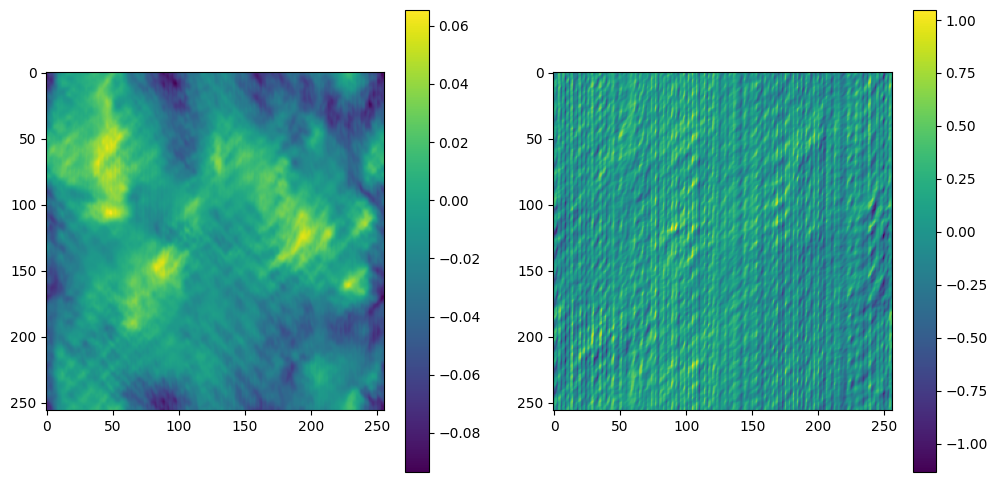

In [99]:
figure(figsize=(12,6))
subplot(121)
imshow(iv[:,:,1]);colorbar();
subplot(122)
imshow(cV1[:,:,1]);colorbar();